In [1]:
import logging
import time
import os
import pickle
import math

import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

#import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
#import tensorflow_text  # pylint: disable=unused-import
import pandas as pd
import numpy as np
import re
import seaborn as sns

from sklearn.model_selection import train_test_split

import jellyfish 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model,  Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dropout, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Concatenate
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Attention
from tensorflow.keras.optimizers import Adam, Adagrad
from keras.losses import sparse_categorical_crossentropy
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
import random

## 52 Protein -ve cis elements Pichia-CLM

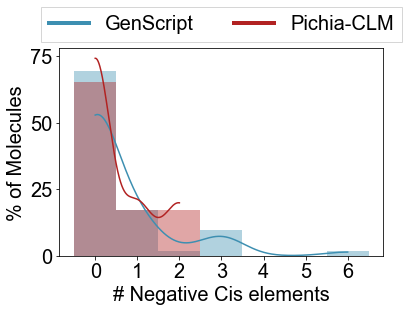

In [2]:
Cis_52 = pd.read_excel("./CodonTransformerPpr_Data/52protein_NegCisElements.xlsx")
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (6,6)
f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)


font = font_manager.FontProperties(family='Arial',
                                   weight='normal',
                                style='normal', size=20)


# sns.kdeplot(Cis_52['Arch1_CIS'].values,
#    fill=True, common_norm=False, color='firebrick', 
#    alpha=.4, linewidth=0)
# # sns.distplot(Cis_52['genewiz_CIS'].values)
# sns.kdeplot(Cis_52['GenScript_CIS'].values,
#    fill=True, common_norm=False, color= '#3D8FB1',
#    alpha=.4, linewidth=0)


# sns.distplot(Cis_52['genewiz_CIS'].values)
sns.histplot(Cis_52['GenScript_CIS'].values, bins = np.arange(-0.5, 7.5), multiple="stack",
   fill=True, common_norm=False, color= '#3D8FB1', kde = True,
   alpha=.4, linewidth=0, stat = 'percent')
sns.histplot(Cis_52['Arch1_CIS'].values,bins = np.arange(-0.5, 7.5), multiple="stack",
   fill=True, common_norm=False, color='firebrick', kde = True,
   alpha=.4, linewidth=0, stat = 'percent')

ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(np.arange(0, 7, 1), **hfont)
ax.set_yticks(np.arange(0, 76, 25))
ax.set_yticklabels(np.arange(0, 76, 25), **hfont)
ax.set_xlabel('# Negative Cis elements', **hfont)
ax.set_ylabel('% of Molecules', **hfont)
leg = ax.legend(['GenScript','Pichia-CLM'], loc = "upper center",  bbox_to_anchor=(0.5, 1.25),
                  ncol=2, fancybox=False, shadow=False, fontsize = 20, prop = font)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

plt.savefig("52proteins_NegCisElements.pdf", dpi = 600, bbox_inches = "tight")

## 6 Molecules - Data

In [3]:
Mol_Names = ['hGCSF','hGH','3B2','RBDJ','HSA','Her_HC', 'Her_LC']
Methods = ['Arch1', 'Genescript', 'Thermo',  'Azenta','IDT']

Data = {}
NegCis = {}
RNAFold = {}
Titer = {}
Data_sub = {}
cnt_m = 0
Corr_Mol = {}
for m in Mol_Names:
    Data[m] = pd.read_excel("UnivariateProperties.xlsx", m)
    
    if m in ['hGH','hGCSF','HSA']:
        A_list = ['Native']+Methods
    else:
        A_list = Methods

    Data_sub[m] = Data[m].loc[Data[m].iloc[:,0].isin(A_list), :]
    Data_sub[m] = Data_sub[m].set_index('Method').loc[A_list].reset_index()
    NegCis[m] = Data_sub[m]["Negative CIS Elements "]
    RNAFold[m] = Data_sub[m]["RNAFold"]
    Titer[m] = Data_sub[m]["Titer"]
        
    Data_sub[m] = Data_sub[m].drop(columns=["Negative CIS Elements ",'Negative repeat Elements', 'RNAFold'])
    Data_sub[m]['Titer'] = Data_sub[m]['Titer']/Data_sub[m]['Titer'].max()
        
    Corr_Mol[m] = Data_sub[m].corr(method = 'pearson')

    if cnt_m == 0:
        Data_stitch = Data_sub[m]
    else:
        Data_stitch = pd.concat((Data_stitch, Data_sub[m]), axis = 0)
    cnt_m = cnt_m + 1

## -Ve Cis Elements plots

For the molecules tested.

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (6,6)

yticklabels = ['Pichia-CLM', 'Genscript', 'Thermo',  'Azenta','IDT']
xticklabels = ['hGCSF','hGH','3B2','RBDJ','HSA','Trast-HC', 'Trast-LC']
NegCis_np = np.zeros((5, len(Mol_Names)))

cnt_m = 0
for m in Mol_Names:
    if m in ['HSA', 'hGH', 'hGCSF']:
        NegCis_np[:, cnt_m] =  NegCis[m].values[1:]
    else:
        NegCis_np[:, cnt_m] =  NegCis[m].values
    cnt_m =cnt_m + 1

    
f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

sns.heatmap(NegCis_np,xticklabels= Mol_Names,#vmin=-1, vmax=1,
                        linewidths=2,  linecolor = 'black',
                    yticklabels = A_list,
            annot=True, fmt='.0f', cmap= sns.cubehelix_palette(as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18}) #, 'color':'black'

  
ax.set_yticklabels(yticklabels, **hfont)
ax.set_xticklabels(xticklabels,rotation = 45, **hfont)

plt.savefig("NegCisElements.pdf", dpi = 600, bbox_inches = "tight")

## RNAFold Ranking

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (6,6)

yticklabels = ['Pichia-CLM', 'Genscript', 'Thermo',  'Azenta','IDT']
xticklabels = ['hGCSF','hGH','3B2','RBDJ','HSA','Trast-HC', 'Trast-LC']
RNA_np = np.zeros((5, len(Mol_Names)))

cnt_m = 0
for m in Mol_Names:
    if m in ['HSA', 'hGH', 'hGCSF']:
        RNA_np[:, cnt_m] =  RNAFold[m].values[1:]/np.min(RNAFold[m].values[1:])
    else:
        RNA_np[:, cnt_m] =  RNAFold[m].values/np.min(RNAFold[m].values)
    cnt_m =cnt_m + 1

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

sns.heatmap(RNA_np,xticklabels= Mol_Names,#vmin=-1, vmax=1,
                        linewidths=2,  linecolor = 'black',
                    yticklabels = A_list,
            annot=True, fmt='.1f', cmap= sns.cubehelix_palette(as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18}) #, 'color':'black'

  
ax.set_yticklabels(yticklabels, **hfont)
ax.set_xticklabels(xticklabels,rotation = 45, **hfont)

plt.savefig("RNA.pdf", dpi = 600, bbox_inches = "tight")

## RNAFold vs Titer

In [ ]:
MoleculeList = [ 'hGH','hGCSF','3B2' ,'RBDJ',  'HerA','HSA']

shapes = ['o', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P','v', 'X', '<', '>']
params = {'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24, 'axes.labelsize': 24}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (6, 6)
f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Arial',
                                   weight='normal',
                                   style='normal', size=20)

import seaborn as sns
cnt_m = 0
for m in MoleculeList:
    if m == 'HerA':
        agg = (RNAFold['Her_LC']/RNAFold['Her_LC'].min() + RNAFold['Her_HC']/RNAFold['Her_HC'].min())/2
#         print(pd.concat((RNAFold[m], Titer[m]), axis=1).corr(method = 'pearson'))
        ax.scatter(agg, Titer['Her_HC']/Titer['Her_HC'].max(), s = 200, c = 'firebrick', marker = shapes[cnt_m], alpha = 0.8)
    else:
        agg = RNAFold[m]/RNAFold[m].min()
        ax.scatter(agg, Titer[m]/Titer[m].max(), s = 200, c = 'firebrick', marker = shapes[cnt_m], alpha = 0.8)
    cnt_m = cnt_m + 1

legend_names = [ 'hGH','hGCSF','3B2' ,'RBDJ',  'Trast','HSA']

ax.set_xlim([0.4, 1.05])
ax.set_ylim([0.2, 1.05])
ax.set_xlabel('Normalized \n RNA fold energy', **hfont)
ax.set_ylabel('Normalized \n Titer', **hfont)
ax.set_xticks(np.arange(0.4,1.01, 0.2))
ax.set_xticklabels(np.round(np.arange(0.4,1.01, 0.2),2), **hfont)
ax.set_yticks(np.arange(0.4,1.01, 0.2))
ax.set_yticklabels(np.round(np.arange(0.4,1.01, 0.2),2), **hfont)
ax.legend(legend_names, prop = font, loc = "upper center",  bbox_to_anchor=(0.5, 1.4),
          ncol=3, fancybox=False, shadow=False, fontsize = 20)
plt.savefig('./Plots/RNA_Titer.pdf', dpi = 600, bbox_inches = "tight")

# for m in ['3B2','RBDJ', 'HSA', 'Her_LC']:
#     print(m)
#     if m == 'Her_LC':
#         agg = (RNAFold[m]/RNAFold[m].min() + RNAFold['Her_HC']/RNAFold['Her_HC'].min())/2
# #         print(pd.concat((RNAFold[m], Titer[m]), axis=1).corr(method = 'pearson'))
#         plt.scatter(agg, Titer[m]/Titer[m].max())
#     else:
#         agg = RNAFold[m]/RNAFold[m].min() 
#         plt.scatter(agg, Titer[m]/Titer[m].max())

## Distribution

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (6,6)

for ent in np.arange(2,Data_sub['hGH'].shape[1]):
    plt.figure()
    for m in Mol_Names:
        sns.distplot(Data_sub[m].iloc[:,ent])
        
    plt.savefig('./Plots/Uni_Dist/'+list(Data_sub['hGH'].columns)[ent], dpi = 300, bbox_inches = "tight")

## Molecule Specfic.

hGCSF
hGH
3B2
RBDJ
HSA
Her_HC
Her_LC


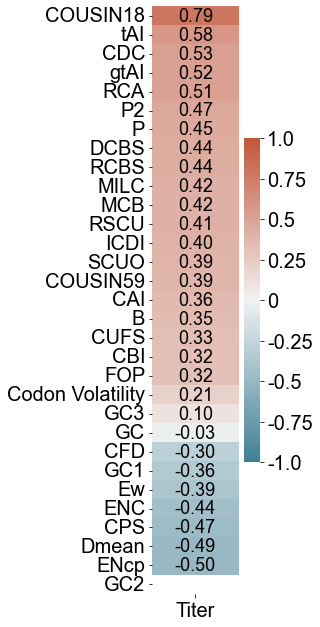

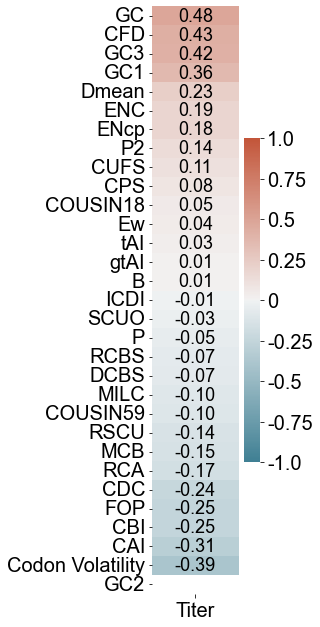

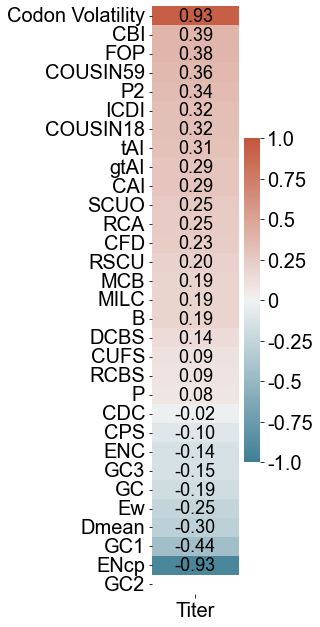

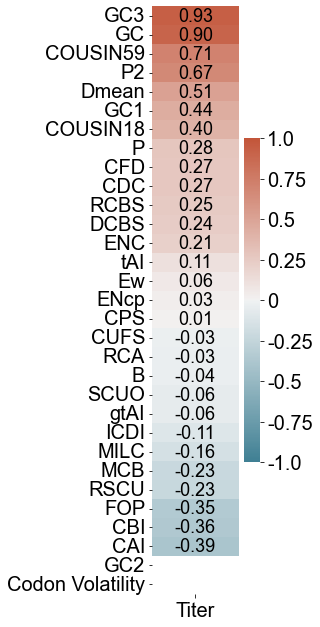

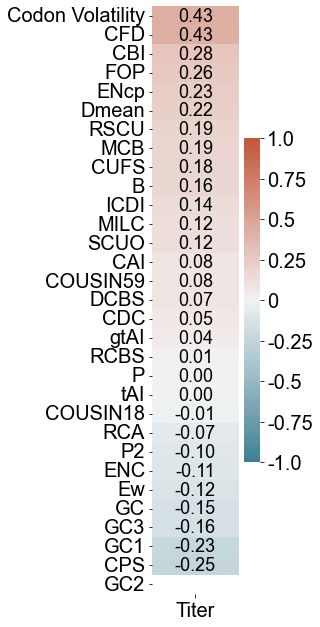

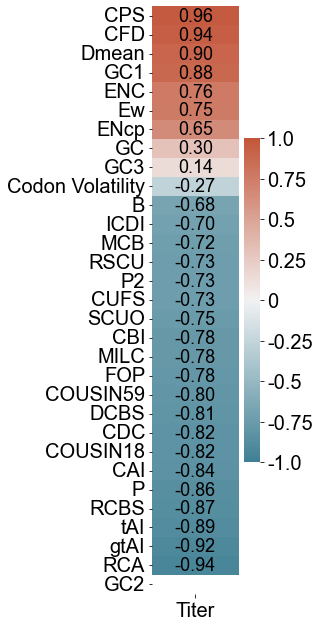

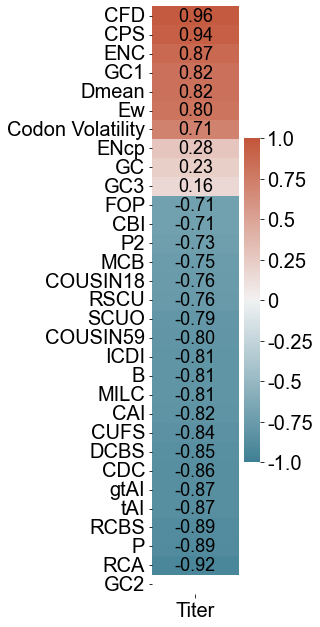

In [11]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,17)

for m in Mol_Names:
    print(m)
    f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
    plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
    df = Corr_Mol[m].sort_values(by = 'Titer',ascending = False)
    h_map = sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],
                            #linewidths=2,  linecolor = 'black',
                        yticklabels = df.index[1:], vmin = -1, vmax = 1,
                annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                    annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
    
    ax.set_xticklabels(['Titer'], **hfont)
    ax.set_yticklabels(df.index[1:], **hfont)
    cbar = h_map.collections[0].colorbar
    cbar.ax.set_yticks([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0], **hfont)
    cbar.ax.set_yticklabels([-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0], **hfont)
    plt.savefig('./Plots/MolSpecCorr/'+m+'.pdf', dpi = 600, bbox_inches = "tight")

## Average across molecules

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,17)

data_np = np.zeros((Corr_Mol[m].shape[0], len(Mol_Names)))
cnt_m = 0
for m in Mol_Names:
    data_np[:,cnt_m] = Corr_Mol[m]['Titer']
    cnt_m = cnt_m + 1
    
df = pd.DataFrame(np.mean(data_np,axis = 1))
df_std = pd.DataFrame(np.std(data_np,axis = 1))
df.columns = ['Titer']
df.index = Corr_Mol[m].index
df = df.sort_values(by = 'Titer',ascending = False)
    
f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = df.index[1:],
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index[1:], **hfont)

In [ ]:
df_std 

## Overall. CategorySpecific

### Dataprep

In [ ]:
non_uniformity = ['RSCU', 'ENC', 'RCBS', 'DCBS', 'CDC', 'MILC', 'ICDI','SCUO', 'Ew', 'P', 'MCB']
host_frequency = ['CAI', 'CFD','FOP', 'COUSIN18', 'COUSIN59', 'CBI', 'Dmean', 'RCA', 'CUFS', 'B']
tRNA = ['tAI', 'gtAI', 'P2']
complex_pattern = ['GC','GC1', 'GC2', 'GC3', 'ENcp', 'CPS', 'Codon Volatility']


print(Data_stitch[non_uniformity].shape)
print(Data_stitch[host_frequency].shape)
print(Data_stitch[tRNA].shape)
print(Data_stitch[complex_pattern].shape)
print(11+10+3+7)

Data_1 = Data_stitch[['Titer']+non_uniformity]
Data_2 = Data_stitch[['Titer']+host_frequency]
# Data_3 = Data_stitch[['Titer']+tRNA]
Data_4 = Data_stitch[['Titer']+tRNA+complex_pattern]


In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,16)

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

df = Data_stitch.corr(method = 'pearson').sort_values(by = 'Titer',ascending = False)

sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],vmin=-1, vmax=1,
                        linewidths=1,  #linecolor = 'black',
                    yticklabels =df.index[1:],
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index[1:], **hfont)

plt.savefig("All.pdf", dpi = 600, bbox_inches = "tight")

### Non Uniform

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,6)

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

df = Data_1.corr(method = 'pearson').sort_values(by = 'Titer',ascending = False)

sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],vmin=-1, vmax=1,
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = non_uniformity,
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index[1:], **hfont)
plt.savefig("NonUniform.pdf", dpi = 600, bbox_inches = "tight")

### Host Frequency

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,6)

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

df = Data_2.corr(method = 'pearson').sort_values(by = 'Titer',ascending = False)

sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],vmin=-1, vmax=1,
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = host_frequency,
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index[1:], **hfont)
plt.savefig("HostFrequency.pdf", dpi = 600, bbox_inches = "tight")

### tRNA

In [ ]:
# params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
# hfont = {'fontname':'Arial'}
# plt.rcParams.update(params)
# plt.rcParams["figure.figsize"] = (2,3)

# f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
# plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

# df = Data_3.corr(method = 'pearson').sort_values(by = 'Titer',ascending = False)

# sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],
#                         #linewidths=2,  linecolor = 'black',
#                     yticklabels = tRNA,vmin=-1, vmax=1,
#             annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
#                 annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
# ax.set_xticklabels(['Titer'], **hfont)
# ax.set_yticklabels(df.index, **hfont, rotation = 0)
# plt.savefig("tRNA.pdf", dpi = 600, bbox_inches = "tight")

### Complex Pattern

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,6)

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)

df = Data_4.corr(method = 'pearson').sort_values(by = 'Titer',ascending = False)

sns.heatmap(df.iloc[1:,0:1],xticklabels= ['Titer'],vmin=-1, vmax=1,
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = tRNA+complex_pattern,
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index[1:], **hfont)
plt.savefig("ComplexPattern.pdf", dpi = 600, bbox_inches = "tight")

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,17)

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
df = Correlation.loc[:, 0:1].sort_values(by = 'Titer',ascending = False)
sns.heatmap(df,xticklabels= ['Titer'],
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = df.index,
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index, **hfont)

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (2,17)

f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
df = Correlation.iloc[1:, 0:1].sort_values(by = 'Titer',ascending = False)
sns.heatmap(df,xticklabels= ['Titer'],
                        #linewidths=2,  linecolor = 'black',
                    yticklabels = df.index,
            annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
                annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
ax.set_xticklabels(['Titer'], **hfont)
ax.set_yticklabels(df.index, **hfont)

In [ ]:
# params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
# hfont = {'fontname':'Arial'}
# plt.rcParams.update(params)
# plt.rcParams["figure.figsize"] = (2,17)

# for m in Mol_Names:
#     f, ax = plt.subplots(1,1, sharex= False, facecolor='w')
#     plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
#     df = Corr_Mol[m].iloc[1:, 0:1].sort_values(by = 'Titer',ascending = False)
#     sns.heatmap(df,xticklabels= ['Titer'],
#                             #linewidths=2,  linecolor = 'black',
#                         yticklabels = df.index,
#                 annot=True, fmt='.2f', cmap= sns.diverging_palette(220, 20, as_cmap=True), #'YlGnBu', 'crest'
#                     annot_kws = {'fontname': 'Arial', 'fontsize': 18, 'color':'black'}) #,annot=True,fmt=".2f", linewidth=.5
#     ax.set_xticklabels(['Titer'], **hfont)
#     ax.set_yticklabels(df.index, **hfont)

## EDA

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

classes = np.zeros((Data_stitch.shape[0], 1))

for i in range(0, Data_stitch.shape[0]):
    if Data_stitch.iloc[i,1:2].values >=0.99:
        classes[i,0] = 1
    else:
        classes[i,0] = 0

In [ ]:
clf = DecisionTreeClassifier(random_state=1234, max_depth = 4)
model = clf.fit(Data_stitch.iloc[:,2:], classes)

text_representation = tree.export_text(clf)
# print(text_representation)

with open("decistion_tree_clf.log", "w") as fout:
    fout.write(text_representation)
    
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=Data_stitch.columns[2:],
#                    class_names=iris.target_names,
                   filled=True)

In [ ]:
clf = DecisionTreeRegressor(random_state=1234, max_depth = 3)
model = clf.fit(Data_stitch.iloc[:,2:], Data_stitch.iloc[:,1:2])

text_representation = tree.export_text(clf)
# print(text_representation)

with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)
    
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,feature_names=Data_stitch.columns[2:],
                   filled=True)

## Gaussian Processes Regression

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern

X = Data_stitch.iloc[:,2:]
y = Data_stitch['Titer']
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

kernel = Matern(length_scale = [1]*X_sc.shape[1], nu =1.5) #+ WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_sc, y)

In [ ]:
print(gpr.kernel_)
print(gpr.kernel_.length_scale)

In [ ]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (3,3)

y_ts = gpr.predict(X_sc)
plt.scatter(y, y_ts)
plt.plot(y, y)

Kernel_df = pd.concat((pd.DataFrame(list(Data_stitch.columns)[2:]),
pd.DataFrame(gpr.kernel_.length_scale)), axis = 1)
Kernel_df.columns = ['Metric', 'Len_Scale']
print(Kernel_df.sort_values(by = ['Len_Scale']))

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

reg = Ridge(alpha = 0.1).fit(X_sc, y)
y_ts_lr = reg.predict(X_sc)

plt.scatter(y, y_ts_lr)
plt.plot(y,y)

print(reg.coef_)

## Gradient Boosting Machine

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbm= GradientBoostingRegressor(n_estimators = 30, max_depth =2, 
                               random_state=0)
gbm.fit(X_sc, y)

y_ts_gbm = gbm.predict(X_sc)
plt.scatter(y,y_ts_gbm)
plt.plot(y,y)

print(gbm.feature_importances_)

GBM_df = pd.concat((pd.DataFrame(list(Data_stitch.columns)[2:]),
pd.DataFrame(gbm.feature_importances_)), axis = 1)

GBM_df.columns = ['Metric', 'GBM_FI']
print(GBM_df.sort_values(by = ['GBM_FI'], ascending = False))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=3, n_estimators = 15, 
                           random_state=0)
rf.fit(X_sc, y)

y_ts_rf = rf.predict(X_sc)
plt.scatter(y,y_ts_rf)
plt.plot(y,y)

print(rf.feature_importances_)

RF_df = pd.concat((pd.DataFrame(list(Data_stitch.columns)[2:]),
pd.DataFrame(rf.feature_importances_)), axis = 1)

RF_df.columns = ['Metric', 'RF_FI']
print(RF_df.sort_values(by = ['RF_FI'], ascending = False))